In [1]:
import matplotlib.pyplot as plt
from scipy.optimize import minimize
plt.style.use('Solarize_Light2')
import pandas as pd
import numpy as np

from tqdm import tqdm
import plotly
import plotly.graph_objects as go
import yfinance as yf
from datetime import timedelta, datetime
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import plotting

In [2]:
tickers = ['PETR4.SA', 'MGLU3.SA', 'JBSS3.SA', 'HASH11.SA','ITIT11.SA', 'BCFF11.SA']
n_assets = 3
n_portfolios = 100

mkt_close_values_df = pd.DataFrame()

for ticker in tickers:
    data = yf.download(ticker, start = "2021-01-01" , end = "2024-01-01")
    mkt_close_values_df[ticker] = data['Adj Close']
    
log_returns = np.log(mkt_close_values_df / mkt_close_values_df.shift(1)).dropna()
log_returns

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,PETR4.SA,MGLU3.SA,JBSS3.SA,HASH11.SA,ITIT11.SA,BCFF11.SA
Date,,,,,,
2022-03-22,-0.004418,0.015612,-0.018236,0.036485,-0.006692,-0.015215
2022-03-23,0.013507,0.032179,-0.016096,-0.035119,0.000000,-0.013315
2022-03-24,0.011478,0.095310,0.011757,0.038801,0.001427,0.007285
2022-03-25,-0.003708,-0.009132,-0.037949,-0.002102,0.026327,0.009931
2022-03-28,-0.021910,-0.010761,0.016242,0.079112,0.000278,0.008201
...,...,...,...,...,...,...
2023-12-21,0.000275,-0.004773,-0.008825,0.010563,0.001442,0.026908
2023-12-22,0.009572,0.014252,0.002013,0.005688,0.001178,-0.001107
2023-12-26,0.015931,-0.004728,0.005214,-0.030921,0.000523,0.018651


In [3]:
mu = expected_returns.mean_historical_return(mkt_close_values_df)
S = risk_models.sample_cov(mkt_close_values_df)

ef = EfficientFrontier(mu, S)
raw_weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
ef.save_weights_to_file("weights.csv") 
print(cleaned_weights)
ef.portfolio_performance(verbose=True)

OrderedDict([('PETR4.SA', 0.25318), ('MGLU3.SA', 0.0), ('JBSS3.SA', 0.0245), ('HASH11.SA', 0.0), ('ITIT11.SA', 0.68487), ('BCFF11.SA', 0.03745)])
Expected annual return: 22.9%
Annual volatility: 13.5%
Sharpe Ratio: 1.55


(0.22928578316629336, 0.13485446112137445, 1.5519381518860376)

In [4]:
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices


latest_prices = get_latest_prices(mkt_close_values_df)

da = DiscreteAllocation(raw_weights, latest_prices, total_portfolio_value=10000)
allocation, leftover = da.greedy_portfolio()
print("Discrete allocation:", allocation)
print("Funds remaining: ${:.2f}".format(leftover))

Discrete allocation: {'ITIT11.SA': 93, 'PETR4.SA': 73, 'BCFF11.SA': 42, 'JBSS3.SA': 10}
Funds remaining: $6.98


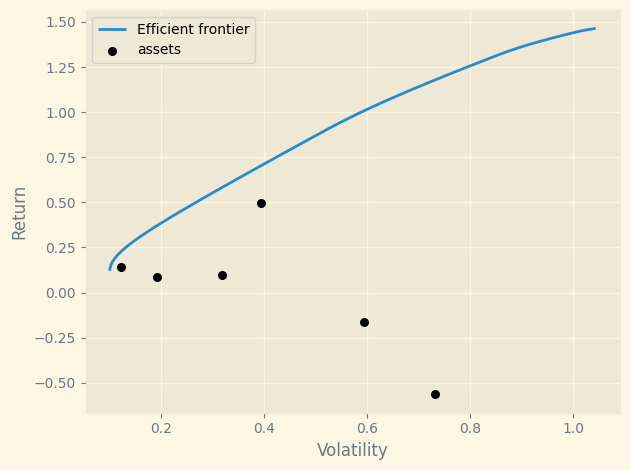

In [5]:
ef = EfficientFrontier(mu, S, weight_bounds=(None, None))

fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=True)

plt.show()

OrderedDict([('PETR4.SA', 0.25318), ('MGLU3.SA', 0.0), ('JBSS3.SA', 0.0245), ('HASH11.SA', 0.0), ('ITIT11.SA', 0.68487), ('BCFF11.SA', 0.03745)])
Expected annual return: 22.9%
Annual volatility: 13.5%
Sharpe Ratio: 1.55


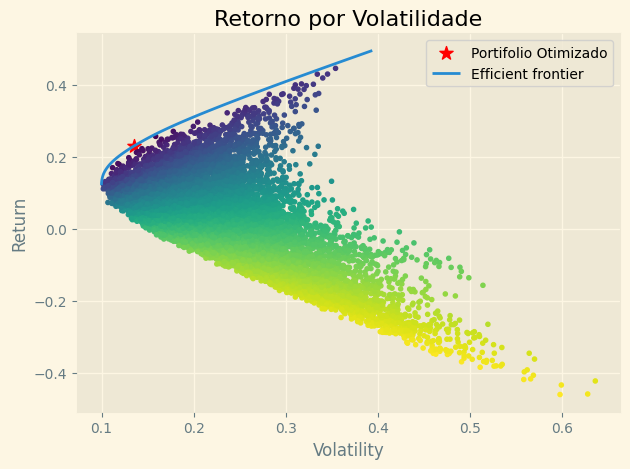

In [9]:
mu = expected_returns.mean_historical_return(mkt_close_values_df)
S = risk_models.sample_cov(mkt_close_values_df)

ef = EfficientFrontier(mu, S)
raw_weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
ef.save_weights_to_file("weights.csv") 
print(cleaned_weights)
ef.portfolio_performance(verbose=True)

fig, ax = plt.subplots()

ef_tangent = EfficientFrontier(mu, S)
ef_tangent.max_sharpe()
ret_tangent, std_tangent, _ = ef_tangent.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Portifolio Otimizado")

ef_plot = EfficientFrontier(mu, S)
plotting.plot_efficient_frontier(ef_plot, ax=ax, show_assets=False)

n_samples = 10000
w = np.random.dirichlet(np.ones(ef.n_assets), n_samples)
rets = w.dot(ef.expected_returns)
stds = np.sqrt(np.diag(w @ ef.cov_matrix @ w.T))
sharpes = rets / stds
ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")

ax.set_title("Retorno por Volatilidade")
ax.legend()
plt.tight_layout()
plt.savefig("ef_scatter.png", dpi=200)
plt.show()